In [4]:
import pandas as pd
import numpy as np
import joblib

In [25]:
hdb_resale_data = pd.read_csv('data/processed/hdb_resale_data_final.csv', index_col=0)

In [16]:
hdb_resale_data.shape

(249857, 13)

In [17]:
hdb_resale_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,num_mrts_within_1km,min_dist_to_mrt_km
_id,,,,,,,,,,,,,
1,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0,1,0.352915
2,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0,0,0.816023
3,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0,1,0.229604
4,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0,1,0.664472
5,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0,0,0.923402


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [7]:
def create_preprocessor(numerical_cols, categorical_cols):
    numerical_transformer = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    return preprocessor

<h2> Basic Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
y = np.log(hdb_resale_data['resale_price'])  

In [14]:
numerical_columns_linreg = hdb_resale_data.select_dtypes(include=['int64', 'float64']).columns.drop(['resale_price', 'lease_commence_date', 'num_mrts_within_1km'])
categorical_columns_linreg = hdb_resale_data.select_dtypes(include=['object', 'category']).columns.drop(['month', 'block'])

preprocessor_linreg = create_preprocessor(numerical_columns_linreg, categorical_columns_linreg)

X_linreg = hdb_resale_data.drop(['month', 'block', 'resale_price', 'lease_commence_date', 'num_mrts_within_1km'], axis=1)

X_processed_linreg = preprocessor_linreg.fit_transform(X_linreg)

In [ ]:
# ------------------------------------------------------------------------------
# Training Random Forest Regressor
# ------------------------------------------------------------------------------

'''
linreg_model = LinearRegression()

scoring = {
    "r2": "r2",
    "rmse": make_scorer(
        lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
    )
}

cv_results = cross_validate(linreg_model, X_processed_linreg, y, cv=kf, scoring=scoring)

print("Average R² score:", np.mean(cv_results["test_r2"]))
print("Average RMSE:", np.mean(cv_results["test_rmse"]))

# Final fit on full dataset
linreg_model.fit(X_processed_linreg, y)
joblib.dump(linreg_model, "models/linear_regression.pkl")
'''

Average R² score: 0.7575195793383349
Average RMSE: 0.16793482289514844


['models/linear_regression.pkl']

In [28]:
# Load Linear Regression model
linreg_model = joblib.load("models/linear_regression.pkl")

<h2> Ridge Regression Model

In [57]:
from sklearn.linear_model import Ridge

In [ ]:
numerical_columns_ridge = hdb_resale_data.select_dtypes(include=['int64', 'float64']).columns.drop(['resale_price'])
categorical_columns_ridge = hdb_resale_data.select_dtypes(include=['object', 'category']).columns.drop(['month', 'block'])

preprocessor_ridge = create_preprocessor(numerical_columns_ridge, categorical_columns_ridge)

X_ridge = hdb_resale_data.drop(['month', 'block'], axis=1)

X_processed_ridge = preprocessor_ridge.fit_transform(X_ridge)

In [ ]:
# ------------------------------------------------------------------------------
# Training Lasso Regression
# ------------------------------------------------------------------------------

'''
params_ridge = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_model = Ridge()

grid_ridge = GridSearchCV(ridge_model, params_ridge, cv=5, scoring='r2')
grid_ridge.fit(X_processed_ridge, y)

print("Best alpha:", grid_ridge.best_params_)
print("Best R²:", grid_ridge.best_score_)

joblib.dump(grid_ridge, "models/ridge_regression_gridsearch.pkl")
'''

Best alpha: {'alpha': 100}
Best R²: 0.7457609188504882


['models/ridge_regression_gridsearch.pkl']

In [48]:
# Load Ridge Regression model
grid_ridge = joblib.load("models/ridge_regression_gridsearch.pkl")

<h2> Random Forest Regression

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# ------------------------------------------------------------------------------
# Training Random Forest Regressor
# ------------------------------------------------------------------------------

'''
X_processed_rf = X_processed_linreg

params_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2]
}

rf_model = RandomForestRegressor(random_state=42)

grid_rf = GridSearchCV(
    rf_model, 
    param_grid=params_rf,
    cv=kf,
    scoring='r2',
    n_jobs=1, 
    verbose=2)

grid_rf.fit(X_processed_rf, y)

print("Best parameters:", grid_rf.best_params_)
print("Best R²:", grid_rf.best_score_)

# Save
joblib.dump(grid_rf, "models/random_forest_gridsearch.pkl")
'''

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=15.7min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=15.2min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=15.3min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=15.0min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=14.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=29.1min
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=29.0min
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=29.5min
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=29.1min
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=28.4min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=10.3min
[CV] END max_depth=10, min_sa

In [39]:
# Load Random Forest model
grid_rf = joblib.load("models/random_forest_gridsearch.pkl")
print("Best parameters:", grid_rf.best_estimator_)

Best parameters: RandomForestRegressor(n_estimators=200, random_state=42)


Train R²: 0.9934
Test R² : 0.9932


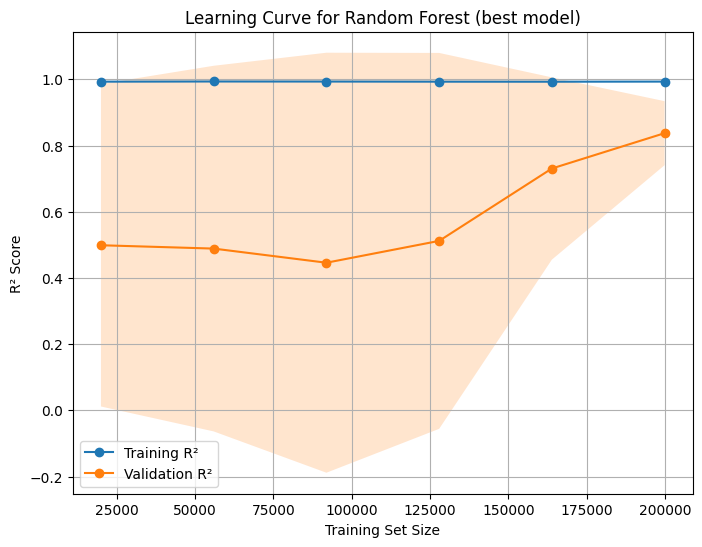

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

X_processed_rf = X_processed_linreg

# Instead of retraining, just grab the trained best model
best_rf = grid_rf.best_estimator_

# Split into train and test for evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_processed_rf, y, test_size=0.2, random_state=42
)

# Check R²
train_r2 = r2_score(y_train, best_rf.predict(X_train))
test_r2 = r2_score(y_test, best_rf.predict(X_test))

print(f"Train R²: {train_r2:.4f}")
print(f"Test R² : {test_r2:.4f}")

# --- Learning curve ---
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_processed_rf, y, cv=5, n_jobs=1,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="r2"
)

# Compute mean/std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training R²")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, test_mean, 'o-', label="Validation R²")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve for Random Forest (best model)")
plt.legend()
plt.grid(True)
plt.show()


<h2> XGBoost Model

In [59]:
from xgboost import XGBRegressor

In [ ]:
# ------------------------------------------------------------------------------
# Training Random Forest Regressor
# ------------------------------------------------------------------------------

'''
X_processed_xgb = X_processed_linreg

param_grid_xgb = {
    'n_estimators': [200, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb_model = XGBRegressor(random_state=42)

grid_xgb = GridSearchCV(
    xgb_model, 
    param_grid=param_grid_xgb, 
    cv=5, 
    scoring='r2', 
    n_jobs=2,
    verbose=2)

grid_xgb.fit(X_processed_xgb, y)

print("Best parameters:", grid_xgb.best_params_)
print("Best R²:", grid_xgb.best_score_)

joblib.dump(grid_xgb, "models/xgb_gridsearch.pkl")
'''

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Best R²: 0.8005152323989645


In [32]:
# Load XGB model
grid_xgb = joblib.load("models/xgb_gridsearch.pkl")
print("Best parameters:", grid_xgb.best_estimator_)

Best parameters: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)


<h1>All model Evaluation

In [54]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_processed_linreg, y, test_size=0.2, random_state=42)

models = {
    'LinearRegression': linreg_model,
    'RidgeRegression': grid_ridge,
    'RandomForest': grid_rf,
    'XGBoost': grid_xgb
}

for model_name, model in models.items():
    print(f'Evaluate: {model_name}')

    y_pred = models[model_name].predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Best MSE: {mse}')
    print(f'Best RMSE: {np.sqrt(mse)}')
    print(f'Best R-squared: {r2}\n')


Evaluate: LinearRegression
Best MSE: 0.0283449602712867
Best RMSE: 0.16835961591571388
Best R-squared: 0.7580881194124137

Evaluate: RidgeRegression
Best MSE: 0.028344966047244322
Best RMSE: 0.1683596330693445
Best R-squared: 0.7580880701171331

Evaluate: RandomForest
Best MSE: 0.0007925026773515388
Best RMSE: 0.028151424073242528
Best R-squared: 0.993236335094002

Evaluate: XGBoost
Best MSE: 0.007564128205273953
Best RMSE: 0.08697199667291738
Best R-squared: 0.9354434629073354



<h2>POST COVID DATA ONLY

In [29]:
hdb_resale_data['month'] = pd.to_datetime(hdb_resale_data['month'])
hdb_resale_from_2020 = hdb_resale_data[hdb_resale_data['month'] >= '2020-01-01']

hdb_resale_from_2020.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,num_mrts_within_1km,min_dist_to_mrt_km
_id,,,,,,,,,,,,,
64257,2020-01-01,ANG MO KIO,3 ROOM,208,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,1976,55,265000.0,0,0.902255
64258,2020-01-01,ANG MO KIO,3 ROOM,307C,ANG MO KIO AVE 1,19 TO 21,70.0,Model A,2012,91,470000.0,1,0.674136
64259,2020-01-01,ANG MO KIO,3 ROOM,319,ANG MO KIO AVE 1,01 TO 03,73.0,New Generation,1977,56,230000.0,1,0.563682
64260,2020-01-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,New Generation,1976,55,280000.0,0,0.836529
64261,2020-01-01,ANG MO KIO,3 ROOM,556,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,59,220000.0,0,0.923578


In [84]:
num_cols = hdb_resale_from_2020.select_dtypes(include=['int64', 'float64']).columns.drop(['resale_price'])
cat_cols = hdb_resale_from_2020.select_dtypes(include=['object', 'category']).columns.drop(['block', 'street_name'])

preprocessor = create_preprocessor(num_cols, cat_cols)

X = hdb_resale_from_2020.drop(['month', 'block'], axis=1)

X_processed = preprocessor_ridge.fit_transform(X)
y = np.log(hdb_resale_from_2020['resale_price'])

print(X_processed.shape)
print(y.shape)

(148448, 651)
(148448,)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [63]:
models = {
    'Linear_Regression': LinearRegression(),
    'Random_Forest': RandomForestRegressor(),
    'XGB':XGBRegressor()
}

param_grids = {
    'Linear_Regression' : {},
    'Random_Forest' : {
        'n_estimators': [100, 200],
        'max_depth': [10, 30],
        'min_samples_split': [2],
    },
    'XGB' : {
        'n_estimators': [100, 200],
        'learning_rate': [0.1],
        'max_depth': [3, 6],
    }
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

grids = {}
for model_name, model in models.items():
    print(f'Training and tuning {model_name}...')
    grids[model_name] = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=cv, scoring='r2', n_jobs=-1, verbose=2
    )
    grids[model_name].fit(X_train, y_train)

    print(f'Best parameters for {model_name}: {grids[model_name].best_params_}')
    print(f'Best R2 for {model_name}: {grids[model_name].best_score_}\n')

    joblib.dump(grids[model_name], f'models/{model_name.lower()}_from2020_gridsearch.pkl')


Training and tuning Linear_Regression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters for Linear_Regression: {}
Best R2 for Linear_Regression: 0.9495891055166523

Training and tuning Random_Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for Random_Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Best R2 for Random_Forest: 0.9594833503401877

Training and tuning XGB...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters for XGB: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best R2 for XGB: 0.9457526706108057



In [64]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

for model_name, grid in grids.items():
    y_pred_train = grid.predict(X_train)
    y_pred_test = grid.predict(X_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f"{model_name} -> Train R2: {r2_train:.4f}, Test R2: {r2_test:.4f}, Test RMSE: {rmse_test:.2f}")


Linear_Regression -> Train R2: 0.9504, Test R2: 0.9501, Test RMSE: 0.07
Random_Forest -> Train R2: 0.9926, Test R2: 0.9646, Test RMSE: 0.06
XGB -> Train R2: 0.9503, Test R2: 0.9471, Test RMSE: 0.08


Very solid baseline model

In [97]:
hdb_resale_from_2020['storey_range'].unique()

array(['04 TO 06', '19 TO 21', '01 TO 03', '07 TO 09', '10 TO 12',
       '16 TO 18', '13 TO 15', '28 TO 30', '25 TO 27', '22 TO 24',
       '34 TO 36', '31 TO 33', '37 TO 39', '46 TO 48', '40 TO 42',
       '49 TO 51', '43 TO 45'], dtype=object)

In [ ]:
new_data = pd.DataFrame([
    { 'month': '2025-08-20', 'town': 'ANG MO KIO', 'flat_type': '3 ROOM', 'block': '124', 'street_name': 'ANG MO KIO AVE 6', 'storey_range': '7 TO 9', 'floor_area_sqm': 67.0, 'flat_model': 'New Generation', 'lease_commence_date': 1977, 'remaining_lease': 52, 'resale_price': 430000.0,  'num_mrts_within_1km': 1, 'min_dist_to_mrt_km': 0.9},
    { 'month': '2025-08-20', 'town': 'JURONG EAST', 'flat_type': '3 ROOM', 'block': '247', 'street_name': 'Jurong East St 24', 'storey_range': '13 TO 15', 'floor_area_sqm': 68.0, 'flat_model': 'New Generation', 'lease_commence_date': 1981, 'remaining_lease': 56, 'resale_price': 492888.0,  'num_mrts_within_1km': 2, 'min_dist_to_mrt_km': 0.6}
])

In [113]:
new_X = new_data.drop(['month', 'block'], axis=1)

new_X_processed = preprocessor_ridge.transform(new_X)

y = np.log(new_data['resale_price'])
new_X_processed.shape

(2, 651)

In [114]:
np.exp(grids['Linear_Regression'].predict(new_X_processed))

array([424983.92794162, 385379.0233192 ])

In [101]:
np.exp(grids['Random_Forest'].predict(new_X_processed))

array([377728.66772408, 385683.19704836])

In [102]:
np.exp(grids['XGB'].predict(new_X_processed))

array([392296.47, 380569.22], dtype=float32)